In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Document to Vector
import re, pickle
from time import time
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split

#Model 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
cd /content/drive/My Drive/NLP-Project

/content/drive/My Drive/NLP-Project


In [6]:
train_df=pd.read_csv(r'./Data_NLP/train.csv',index_col=0)
test_df=pd.read_csv(r'./Data_NLP/test.csv',index_col=0)

In [7]:
train_df['flag']='train'
test_df['flag']='test'
all_data_df=pd.concat([train_df,test_df])

In [8]:
all_data_df['text']=all_data_df['text'].fillna("")

In [9]:
data_df=all_data_df[['issue','issue_area','flag','text']]

In [11]:
data_df['issue']=data_df['issue'].replace(np.nan,'-1')

In [12]:
checking missing values
data_df.isnull().sum()

In [13]:
#changing data type
data_df['issue'] = data_df['issue'].astype(int)
data_df['text'] = data_df['text'].astype(str)

In [14]:
def cleanText(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ",words)
    text = words.lower().split()
    return " ".join(text)

In [15]:
data_df['text']=data_df['text'].apply(cleanText)

In [18]:
# data_df = pd.read_csv(r'clean_data.csv')

In [19]:
data_df = data_df[data_df['text'].notna()]

In [20]:
data_df.isnull().sum()

Unnamed: 0    0
issue         0
issue_area    0
flag          0
text          0
dtype: int64

In [21]:
issue_codes=pd.read_csv(r'./Data_NLP/Issue Codes.csv',index_col=0)
issue_label=np.arange(len(issue_codes['code']))
issue_codes['issue_label']=issue_label

In [22]:
issue_codes=issue_codes[['code','issue_label']]
data_df=data_df.merge(issue_codes,how='left',left_on='issue',right_on='code')
data_df=data_df.drop(columns=['code'])
data_df['issue_label']=data_df['issue_label'].replace(np.nan,'-1')
data_df['issue_label'] = data_df['issue_label'].astype(int)

data_df = data_df.drop(data_df[data_df.issue_area == -1].index)

In [23]:
data_df.head()

,Unnamed: 0,issue,issue_area,flag,text,issue_label
0,3026,30130,3,train,sol gen erwin n griswold appellant john g flym...,146
1,214,90380,9,train,appeal supreme court state oklahoma messrs rob...,263
2,4817,100030,10,train,army sergeant ridgway first wife april granted...,2
3,4099,10120,1,train,respondent arrested arraigned committed jail d...,24
4,547,20250,2,train,petitioner veteran entitled benefit veteran pr...,117


In [24]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.9MB/s 
     |████████████████████████████████| 901kB 52.8MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 


In [27]:
tokenizer  = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [28]:
tokenized_text = []
count = 1
for sen in data_df['text']:
    count += 1
    encoded_sentence = tokenizer.encode(sen, add_special_tokens=True, max_length=512, truncation=True)
    tokenized_text.append(encoded_sentence)

pickling_on = open("tokenized_text.pickle", "wb")
pickle.dump(tokenized_text, pickling_on)
pickling_on.close()

In [29]:
# pickle_off = open("tokenized_text.pickle", 'rb')
# tokenized_text = pickle.load(pickle_off)
# pickle_off.close()

In [37]:
MAX_LEN = 256
input_texts = tokenized_text
input_texts = pad_sequences(input_texts, maxlen=MAX_LEN,value=0)

In [40]:
attention_masks = []

for sent in input_texts:
    att_mask = [int(token_id>0) for token_id in sent]
    attention_masks.append(att_mask)
data_df['attention_masks'] = attention_masks

In [41]:
labels = np.array(data_df['issue_area'])

In [42]:
data_df.loc[data_df['issue_area'] <= 0]

,Unnamed: 0,issue,issue_area,flag,text,issue_label,attention_masks


In [50]:
X_train, X_test, y_train, y_test = train_test_split(input_texts, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

train_masks, test_masks, train_mask_label, test_mask_label = train_test_split(attention_masks, labels, test_size=0.2)
train_masks, val_masks, train_mask_label,val_mask_label = train_test_split(train_masks, train_mask_label, test_size=0.2)

batch_size = 32

X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)
test_masks = torch.tensor(test_masks)
train_data = TensorDataset(X_train, train_masks, y_train)
train_sampler = RandomSampler(X_train)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(X_val, val_masks, y_val)
validation_sampler = RandomSampler(X_val)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [52]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=15,output_attentions=False,output_hidden_states=False)
model.cuda() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [53]:
optimizer = AdamW(model.parameters())

In [80]:
epochs = 10
total_steps=len(train_dataloader) *epochs
schdeuler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=total_steps)

In [81]:
loss_values = []
for epch in range(epochs):
    print("Epoch :: " + str(epch))
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        input_masks = batch[1].to(device)
        labels = batch[2].to(device)
        model.zero_grad()
        output = model(input_ids, token_type_ids=None, attention_mask = input_masks, labels=labels)
        loss = output[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        schdeuler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print("Training loss :: " + str(avg_train_loss))
print("Completed training")

Epoch :: 0
Training loss :: 2.1254505798930214
Epoch :: 1
Training loss :: 2.121637775074868
Epoch :: 2
Training loss :: 2.1172606576056707
Epoch :: 3
Training loss :: 2.1143852181377865
Epoch :: 4
Training loss :: 2.1154594180129824
Epoch :: 5
Training loss :: 2.1120863343988145
Epoch :: 6
Training loss :: 2.1119624291147505
Epoch :: 7
Training loss :: 2.110967387046133
Epoch :: 8
Training loss :: 2.1083252969242277
Epoch :: 9
Training loss :: 2.107042385708718
Completed training


In [82]:
loss_values

[2.1254505798930214,
 2.121637775074868,
 2.1172606576056707,
 2.1143852181377865,
 2.1154594180129824,
 2.1120863343988145,
 2.1119624291147505,
 2.110967387046133,
 2.1083252969242277,
 2.107042385708718]

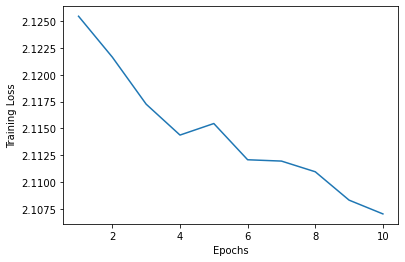

In [83]:
import matplotlib.pyplot as plt
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(epochs, loss_values)
plt.show()

In [84]:
test_data = TensorDataset(X_test, test_masks, y_test)
test_sampler = RandomSampler(X_test)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [85]:
model.eval()
acc = 0
steps = 0
for batch in test_dataloader:
    batch = tuple(tup.to(device) for tup in batch)
    ids, mask, labels = batch
    with torch.no_grad():
        output = model(ids, token_type_ids=None, attention_mask=mask)
    logits = output[0]
    logits=logits.detach().cpu().numpy()
    label_ids = labels.cpu().numpy()
    acc += np.sum(np.argmax(logits, axis=1).flatten() == label_ids.flatten()) / len(label_ids.flatten())
    steps += 1
print("Accuracy :: " + str(acc/steps))

Accuracy :: 0.21898584905660376
